# Editing efficiency analysis

This notebook contains the code to analyze the overall editing efficiency (by C position) for all the validation sgRNAs that we tested. This notebook takes as input the nucleotide_percentage files generated by the BEV_nucleotide_percentage_plots notebook.

In [18]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from IPython.display import Javascript, display

mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
sns.set_context('paper')
sns.set_style('ticks')
boxprops = {'edgecolor': 'k', 'linewidth': 0.5, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 0.5}
stripplot_kwargs = dict({'linewidth': 0.5, 'size': 3, 'alpha': 0.8})
boxplot_kwargs = dict({'boxprops': {'linewidth':0,'facecolor':'w'}, 'medianprops': {'linewidth':1},
                       'whiskerprops': {'linewidth':0}, 'capprops': {'linewidth':0},
                       'width': 0.8,'whis':(10,90)})

## User inputs

<font color='blue'> Please follow steps indicated in blue, then run the notebook to generate output files. If the files are formatted as described in the documentation, the code in the 'Functions' section should not need to be altered. </font> 

**Metainformation file** 

<font color='blue'> <b>Step 1:</b> Please enter the filepath to the metainformation input file used in the allele frequencies notebook. The same file will be used in this notebook. </font> 

In [2]:
global old_input_file
# input_filepath = 'AudreyData/Metainfo_input_f2_r1_ABE.csv'
input_filepath = input("Please enter input filepath here: ")
old_input_file = pd.read_csv(input_filepath)

old_input_file

Please enter input filepath here: AudreyData/Metainfo_input_f2_r1_ABE.csv


,sg,sgRNA_sequence,ref_seq,BEV_start,BEV_end,primer,frame,rev_com,BEV_ref,BEV_test
0,3,ACTTCTCCCGCCGCTACCGC,GCCGGCGACGACTTCTCCCGCCGCTACCGCCGCGACTTCG,327,336,F2_R1,1,False,327;328,335;336
1,4,ACGACTTCTCCCGCCGCTAC,CAGGCCGGCGACGACTTCTCCCGCCGCTACCGCCGCGACT,337,346,F2_R1,1,False,337;338,345;346
2,5,AGAAGTCGTCGCCGGCCTGG,TAGCGGCGGGAGAAGTCGTCGCCGGCCTGGCGGAGGGTCA,347,356,F2_R1,2,True,347;348,355;356


<font color='blue'><b>Step 2:</b> Enter filepath to folder where the files generated by the nucleotide percentage notebook were stored. Please make sure that the filepath ends in a '/'. </font> 

In [3]:
global nuc_per_filepath
# nuc_per_filepath = 'AudreyData/Validation_CRISPResso_results/nucleotide_percentage/'
nuc_per_filepath = input("Please enter filepath to folder with nucleotide percentage outputs here: ")

Please enter filepath to folder with nucleotide percentage outputs here: AudreyData/Validation_CRISPResso_results/nucleotide_percentage/


<font color='blue'><b>Step 3:</b> Enter filepath to folder where the files generated by this notebook will be stored. Please make sure that the filepath ends in a '/'. If the folders in this file path do not currently exist, they will be created when the notebook is run.  </font> 

In [4]:
global output_filepath
output_filepath = 'AudreyData/Validation_CRISPResso_results/'
# output_filepath = input("Please enter output folder filepath here: ")

<font color='blue'><b>Step 4:</b> Enter the name of the gene targeted in experiment. </font> 

In [5]:
global experiment
experiment = input("Please enter gene name here: ")
# next_gene = input("Are there more genes targeted in this experiment? Please enter y for 'yes' or n for 'no.'")
# if next_gene == 'y':
    


Please enter gene name here: BCL2


<font color='blue'><b>Step 5:</b> Please select the type of base editor (BE) used in the samples in input file. 

In [16]:
global be_type

be_type_input = input("Please specify the type of base editor used in the input samples by entering 'A' for A base editor or 'C' for C base editor: ")


Please specify the type of base editor used in the input samples by entering 'A' for A base editor or 'C' for C base editor: A


In [19]:
# Make sure a base editor is selected and not default value

if (be_type_input != 'A') and (be_type_input != 'C'):
    raise Exception('Invalid input. Please enter either A or C to specify base editor.')

else:
    # Run rest of notebook! 
    be_type = be_type_input + 'BE'
    display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

## Functions

In [20]:
'''
This function removes any NaN rows from input_file
'''
def clean_input_file(df):
    df = df.dropna() #drop NaN 
    #dropna() converts int to float, so convert them back
    float_cols = df.select_dtypes(include=['float64']).columns #select subset of df of type float
    for col in float_cols: 
        #get original column index so can replace at correct loc
        index = df.columns.get_loc(col)
        #rename float cols as "float_"col name 
        float_col_name = 'float_' + col
        df = df.rename(columns = {col : float_col_name})
        #overwrite as type int
        float_to_int = df[float_col_name].astype(int).copy()
        df.insert(index, col, float_to_int)
        #drop float column 
        df = df.drop(float_col_name, axis = 1)
    return df

In [21]:
def run(old_input_file):
    
    #check for NaN values i.e. blank rows
    if old_input_file.isnull().values.any(): 
        old_input_file = clean_input_file(old_input_file)

    input_file = old_input_file.copy()
    
    input_file['BEV_reps'] = input_file['BEV_test']
    input_file['Experiment'] = experiment
    offset = []
    nuc_list = []
    sg_list = []
    edits_list = []
    expt_list = []

    for i,r in input_file.iterrows():
        # Open corresponding "nucleotide_percentage" file
        #file_path = '../Data/Validation_CRISPResso_results/nucleotide_percentage/BEV_'+'_'.join(r['BEV_reps'].split(';'))+'_'+r['primer']+'.csv'
        file_path = nuc_per_filepath+'BEV_'+'_'.join(r['BEV_reps'].split(';'))+'_'+r['primer']+'.csv'
        print(file_path)
        data = pd.read_csv(file_path)
        
        # Filter for positions where WT nuc is A or C depending on base editor type 
        if be_type == 'ABE':
            data = data[data['WT'] == 'A']
        elif be_type == 'CBE':
            data = data[data['WT'] == 'C']

        for nuc in ['A','G','T','N','del']:
            col = nuc+'_avg'
            edits_list.extend(data[col].tolist())
            offset.extend(data['offset_position'].tolist())
            nuc_list.extend([nuc] * len(data))
            sg_list.extend([r['sg']] * len(data))
            expt_list.extend([r['Experiment']] * len(data))
    # Scale to percentage
    edits_list = [x*100 for x in edits_list]
    tuples_list = list(zip(edits_list,offset,nuc_list,sg_list,expt_list))
    df = pd.DataFrame(tuples_list, columns = ['Percentage', 'Position','Nucleotide','sg','Experiment'])
    
    if be_type == 'ABE':
        df[df['Nucleotide'] == 'G'].sort_values(by='Percentage',ascending=False).head()
    elif be_type == 'CBE':
        df[df['Nucleotide'] == 'T'].sort_values(by='Percentage',ascending=False).head()
    
    return df

In [22]:
df = run(old_input_file)
save_filepath = output_filepath + 'editing_efficiency_input.csv'
df.to_csv(save_filepath, sep = '\t')

AudreyData/Validation_CRISPResso_results/nucleotide_percentage/BEV_335_336_F2_R1.csv
AudreyData/Validation_CRISPResso_results/nucleotide_percentage/BEV_345_346_F2_R1.csv
AudreyData/Validation_CRISPResso_results/nucleotide_percentage/BEV_355_356_F2_R1.csv


In [23]:
if be_type == 'ABE':
    df.loc[(df['Position'] >= 4) & (df['Position'] <= 8) & (df['Nucleotide'] == 'G'),'Position'].value_counts()
elif be_type == 'CBE':
    df.loc[(df['Position'] >= 4) & (df['Position'] <= 8) & (df['Nucleotide'] == 'T'),'Position'].value_counts()

## Generate plots 

In [24]:
def make_plot(nuc,experiments):
    color_dict = {'A':sns.color_palette('Set2')[0],
                  'G':sns.color_palette('Set2')[1],
                  'T':sns.color_palette('Set2')[2],
                  'del':sns.color_palette('Set2')[4]}
    fig,ax=plt.subplots(figsize=(4,1.5))
    sns.boxplot(x='Position',y='Percentage',data=df.loc[(df['Position'] >= -10) & (df['Position'] <= 20) &
                                                        (df['Nucleotide'] == nuc) & (df['Experiment'].isin(experiments))],
                fliersize=0,**boxplot_kwargs)
    sns.stripplot(x='Position',y='Percentage',data=df.loc[(df['Position'] >= -10) & (df['Position'] <= 20) &
                                                          (df['Nucleotide'] == nuc) & (df['Experiment'].isin(experiments))],
                  color=color_dict[nuc],**stripplot_kwargs)
    ax.set_ylim(0,100)
    if nuc == 'del':
        ax.set_title('deletions',fontsize=8)
    else:
        if be_type == 'ABE':
            ax.set_title('A>'+nuc,fontsize=8)
        elif be_type == 'CBE':
            ax.set_title('C>'+nuc,fontsize=8)
    ax.set_ylabel('% conversion',fontsize=6)
    
    if be_type == 'ABE':
        ax.set_xlabel('position of A', fontsize=6)
    elif be_type == 'CBE':
        ax.set_xlabel('position of C', fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    # format filepath so it's saved as 'folder/BRCA1_T_editing_eff.pdf'
    filepath = output_filepath+'_'.join(experiments)+'_'+nuc+'_editing_eff.pdf'
    Path(output_filepath).mkdir(parents=True, exist_ok=True)
    fig.savefig(filepath, transparent = True)
    return fig,ax

<font color='blue'><b>Step 6:</b> Enter the target nucleotide of interest (T, A, G, C, or del). You can re-run the following cells to change the nucleotide being plotted. </font> 

In [25]:
nuc = input("Please enter target nucleotide here: ")

Please enter target nucleotide here: G


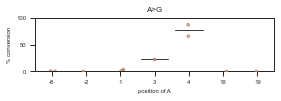

In [26]:
fig,ax = make_plot(nuc,[experiment])